In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
import albumentations as A

# Define dataset path and image size
dataset_path = "data"  # Path to your dataset
image_size = (120, 160)  # Resize to 64x48 for SVM

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4', 'Grupo_5']


LG images

In [2]:
# Function to load images from the LG folder (following the exact structure)
def load_images_from_folder(folder_path):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    # Traverse through the group -> subject -> LG -> session -> anotherfolder -> images
    for group_folder in os.listdir(folder_path):
        group_path = os.path.join(folder_path, group_folder)
        if os.path.isdir(group_path):  # If it is a group folder
            for subject_folder in os.listdir(group_path):
                subject_path = os.path.join(group_path, subject_folder)
                if os.path.isdir(subject_path):  # If it is a subject folder
                    lg_folder = os.path.join(subject_path, "LG")  # Looking specifically for the 'LG' folder
                    if os.path.isdir(lg_folder):  # Only process if 'LG' folder exists
                        # Iterate over sessions inside 'LG' folder
                        for session_folder in os.listdir(lg_folder):
                            session_path = os.path.join(lg_folder, session_folder)
                            if os.path.isdir(session_path):  # Check each session
                                # Iterate over each subfolder inside the session
                                for subfolder in os.listdir(session_path):
                                    subfolder_path = os.path.join(session_path, subfolder)
                                    if os.path.isdir(subfolder_path):  # If it's a subfolder containing images
                                        # Now we go through all the image files
                                        for file in os.listdir(subfolder_path):
                                            if any(file.lower().endswith(ext) for ext in image_extensions):
                                                img_path = os.path.join(subfolder_path, file)
                                                try:
                                                    # Read image in grayscale and resize
                                                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                                                    if img is not None:
                                                        img = cv2.resize(img, image_size)
                                                        images.append(img)
                                                        labels.append(file[6] != '0')  # Assuming the label is based on the file name (0 or 1)
                                                        names.append(file)
                                                except Exception as e:
                                                    corruptedFiles.append((img_path, str(e)))

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    
    # Return the images, labels, and names if any images were found
    if images:
        return np.array(images), np.array(labels), np.array(names)
    else:
        print("No images were loaded.")
        return np.array([]), np.array([]), np.array([])  # Return empty arrays if no images are found

# Load dataset (only from the LG folder)
images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the LG folder with shape {images.shape}")

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the LG folder with shape (2820, 64, 64)


In [3]:
# Reshape images to 1D vectors for SVM input (Flatten each 2D image into a vector)
images = images.reshape(images.shape[0], -1)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

In [4]:
# Initialize SVM classifier
svm = SVC(kernel='rbf', gamma='scale', C=1)

# Train the SVM model
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Print accuracy and classification report
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy on Test Set:  0.7819148936170213
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.00      0.01       247
        True       0.78      1.00      0.88       881

    accuracy                           0.78      1128
   macro avg       0.89      0.50      0.44      1128
weighted avg       0.83      0.78      0.69      1128



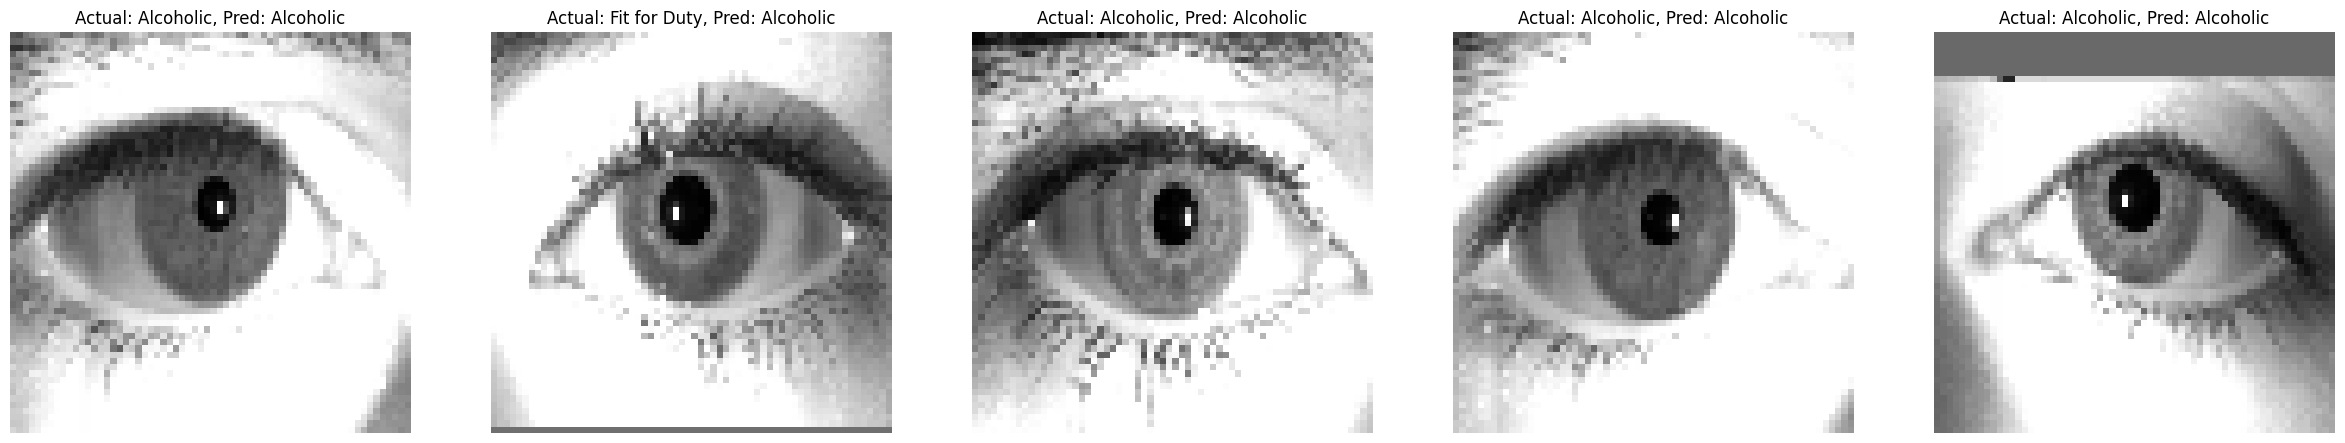

In [5]:
# Optionally, you can visualize some of the images and their predictions
def plot_images(images, labels, preds, num_images=5):
    plt.figure(figsize=(30, 30))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        if labels[i]:
            label='Alcoholic'
        else:
            label='Fit for Duty'
        if preds[i]:
            pred='Alcoholic'
        else:
            pred='Fit for Duty'
        plt.title(f"Actual: {label}, Pred: {pred}")
        plt.axis('off')
    plt.show()

# Visualize some test images with their predictions
plot_images(X_test.reshape(X_test.shape[0], *image_size), y_test, y_pred)

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Dataset parameters
dataset_path = "data"
image_size = (120, 160)  # As per the paper
image_extensions = ["bmp"]  # Update this if other extensions exist

# Function to load images from the LG folder (following the exact structure)
def load_images_from_folder(folder_path):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    # Traverse through the group -> subject -> LG -> session -> anotherfolder -> images
    for group_folder in os.listdir(folder_path):
        group_path = os.path.join(folder_path, group_folder)
        if os.path.isdir(group_path):  # If it is a group folder
            for subject_folder in os.listdir(group_path):
                subject_path = os.path.join(group_path, subject_folder)
                if os.path.isdir(subject_path):  # If it is a subject folder
                    lg_folder = os.path.join(subject_path, "LG")  # Looking specifically for the 'LG' folder
                    if os.path.isdir(lg_folder):  # Only process if 'LG' folder exists
                        # Iterate over sessions inside 'LG' folder
                        for session_folder in os.listdir(lg_folder):
                            session_path = os.path.join(lg_folder, session_folder)
                            if os.path.isdir(session_path):  # Check each session
                                # Iterate over each subfolder inside the session
                                for subfolder in os.listdir(session_path):
                                    subfolder_path = os.path.join(session_path, subfolder)
                                    if os.path.isdir(subfolder_path):  # If it's a subfolder containing images
                                        # Now we go through all the image files
                                        for file in os.listdir(subfolder_path):
                                            if any(file.lower().endswith(ext) for ext in image_extensions):
                                                img_path = os.path.join(subfolder_path, file)
                                                try:
                                                    # Read image in grayscale and resize
                                                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                                                    if img is not None:
                                                        img = cv2.resize(img, image_size)
                                                        images.append(img)
                                                        labels.append(file[6] != '0')  # Assuming the label is based on the file name (0 or 1)
                                                        names.append(file)
                                                except Exception as e:
                                                    corruptedFiles.append((img_path, str(e)))

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    
    # Return the images, labels, and names if any images were found
    if images:
        return np.array(images), np.array(labels), np.array(names)
    else:
        print("No images were loaded.")
        return np.array([]), np.array([]), np.array([])  # Return empty arrays if no images are found

# Load dataset (only from the LG folder)
images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the LG folder with shape {images.shape}")
# Flatten images to vectors
images = images.reshape(images.shape[0], -1)  # Shape (N, 19200)

# Split dataset into train (60%) and test (40%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

# Perform 5-fold cross-validation to tune hyperparameters
svm = SVC(kernel='rbf')
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
}
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters from CV:", grid_search.best_params_)
best_svm = grid_search.best_estimator_

# Train the best model on the full training set
best_svm.fit(X_train, y_train)

# Evaluate on the test set
y_pred = best_svm.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the LG folder with shape (2820, 160, 120)
Best parameters from CV: {'C': 100, 'gamma': 'scale'}
Accuracy on Test Set: 0.8900709219858156
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.68      0.73       247
        True       0.91      0.95      0.93       881

    accuracy                           0.89      1128
   macro avg       0.85      0.81      0.83      1128
weighted avg       0.89      0.89      0.89      1128

